# Code Explanation and Examples

## Introduction

In this notebook, we will discuss and illustrate the implementation of using the CausalBO package. We will provide explanations along with code samples to help you understand the key concepts and steps involved in the code.

## Table of Contents
1. [Prerequisites](#prerequisites)
2. [Code Explanation](#code-explanation)
    1. [Standard CBO Loop](#standard-cbo)
        1. [Importing Libraries](#s-importing-libraries)
        2. [Loading Data](#s-loading-data)
        3. [Causal Bayesian Optimization Algorithm](#s-cbo-alg)
    2. [Custom CBO Loop](#custom-alg)
        1. [Importing Libraries](#c-importing-libraries)
        2. [Loading Data](#c-loading-data)
        3. [Causal Bayesian Optimization Algorithm](#c-cbo-alg)
3. [Result Replication](#result-replication)
## Prerequisites <a name="prerequisites"></a>

Before running the code samples, ensure you have the necessary libraries installed. Installing CausalBO through pip will ensure these dependencies are installed. Otherwise, you can run the following code to install them:

In [13]:
import sys
from tqdm import tqdm
%pip install -r "./venv/requirements.txt"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Code Explanation <a name="code-explanation"></a>

### Standard CBO Loop <a name="standard-cbo"></a>

#### Step 1: Importing Libraries <a name="s-importing-libraries"></a>

Begin by importing all of the necessary libraries for running a simple causal Bayesian optimization task using the included algorithm.

In [14]:
from causalbo.cbo_loop import CBOLoop
from causalbo.sample_data.toy_graph import ToyGraph

c:\Users\100 Acre Wood\Desktop\CBO\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Step 2: Loading Data <a name="s-loading-data"></a>

For the simplest example, some sample DAGs and associated datasets have been provided. We can load all of the data we need by instantiating one of these objects. The object contains information about the graph structure, ground truth functions, and a randomly generated set of noisy observational data.

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]

{'X': [-5, 5], 'Z': [-5, 20]}
          X            Z         Y
0 -7.484275  1780.531006 -1.603078
1 -3.761830    43.487362 -0.747680
2 -3.823818    46.774666 -0.790507
3 -3.555110    34.074268 -2.733463
4 -3.871735    48.553917  0.726369
5 -4.732820   113.567520  0.793136
6 -4.289653    72.483849 -3.005542
7 -5.352627   211.649918 -0.795608
8 -5.363301   214.720337  0.520850
9 -4.419449    84.512566 -0.333838


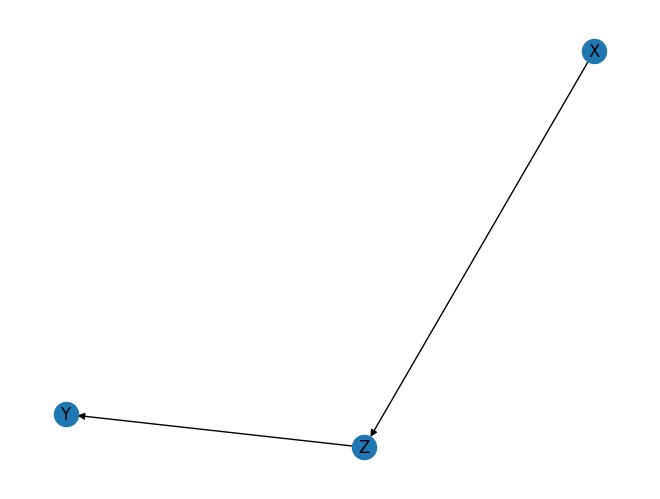

In [15]:
toy_graph = ToyGraph()

# Display sample data
toy_graph.draw()
print(toy_graph.interventional_domain)
print(toy_graph.observational_samples.head(10))

#### Step 3: Causal Bayesian Optimization Algorithm <a name="s-cbo-alg"></a>

Now, we can run the included CBO algorithm, originally developed by V. Aglietti et. al. and adapted for use in this package.

In [16]:
(global_optimum, global_optimal_set, gp, _, _, _, _) = CBOLoop(
        observational_samples=toy_graph.observational_samples,
        graph=toy_graph.graph,
        exploration_set=[['X']],
        num_steps=10,
        num_initial_obs=400,
        num_obs_per_step=20,
        num_max_allowed_obs=1000,
        interventional_domain=toy_graph.interventional_domain,
        type_trial='min',
        objective_function=toy_graph.true_graph,
        early_stopping_iters=2, verbose=False)

print(global_optimum, global_optimal_set, gp)

Iteration 0
Current global optimal set-value-result = ['None']: None -> 2.9534406661987305
Observing 20 new data points.


Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00, 15.20it/s]


Iteration 1
Current global optimal set-value-result = ['None']: None -> 2.9534406661987305
Intervening...


c:\Users\100 Acre Wood\Desktop\CBO\causalbo\cbo_loop.py:145: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventional_data = concat(


Iteration 2
Current global optimal set-value-result = ['X']: [-1.217194702476263] -> -1.7574873073658142
Intervening...
Iteration 3
Current global optimal set-value-result = ['X']: [-1.217194702476263] -> -1.7574873073658142
Intervening...


c:\Users\100 Acre Wood\Desktop\CBO\venv\Lib\site-packages\botorch\fit.py:171: RuntimeWarning: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.
  warn(str(err), RuntimeWarning)


Iteration 4
Current global optimal set-value-result = ['X']: [-1.1485989391803741] -> -1.792286506363347
Intervening...
Iteration 5
Current global optimal set-value-result = ['X']: [-1.1485989391803741] -> -1.792286506363347
Intervening...


KeyboardInterrupt: 

### Custom CBO Loop <a name="custom-alg"></a>

It is also possible to use the provided modules to write a custom loop using BoTorch.

#### Importing Libraries <a name="c-importing-libraries"></a>

These imports will give access to the lower-level modules used in the simple example above to allow for the creation of a custom loop using BoTorch, as well as generating custom data.

In [18]:
from causalbo.modules import CausalMean, CausalRBF
from causalbo.do_calculus import SCM, E_output_given_do
from causalbo.causal_helper_funcs import *

from pandas import DataFrame

import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

#### Loading Data <a name="c-loading-data"></a>

For this example, we will generate some custom data using the same DAG structure and ground truth functions provided in the ToyGraph import.

In [23]:
# Interventional domain
interventional_domain = {'X': [-5,5], 'Z': [-5,20]}

# Graph structure
graph = SCM([('X', 'Z'), ('Z', 'Y')])

# Same structure, deep copy
true_graph = SCM([('X', 'Z'), ('Z', 'Y')])

# Generate observational data
obs_data_x = ToyGraph.X(torch.linspace(-5, 5, 1000).view(-1,1), noise_stdev=1)
obs_data_z = ToyGraph.Z(obs_data_x, noise_stdev=1)
obs_data_y = ToyGraph.Y(obs_data_z, noise_stdev=1)

# Add to dataframe
observational_samples = DataFrame()
observational_samples['X'] = torch.flatten(obs_data_x).tolist()
observational_samples['Z'] = torch.flatten(obs_data_z).tolist()
observational_samples['Y'] = torch.flatten(obs_data_y).tolist()
# Shuffle dataframe into random order
observational_samples.sample(frac=1)
# Fit graph to observational data.
graph.fit(observational_samples)

# Generate objective data
obs_data_x = ToyGraph.X(torch.linspace(-5, 5, 1000).view(-1,1))
obs_data_z = ToyGraph.Z(obs_data_x)
obs_data_y = ToyGraph.Y(obs_data_z)

# Add to dataframe
objective_samples = DataFrame()
objective_samples['X'] = torch.flatten(obs_data_x).tolist()
objective_samples['Z'] = torch.flatten(obs_data_z).tolist()
objective_samples['Y'] = torch.flatten(obs_data_y).tolist()

# Fit graph to objective data.
true_graph.fit(objective_samples)

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00,  9.04it/s]


#### Causal Bayesian Optimization Algorithm <a name="c-cbo-alg"></a>

With our data generated, we can now write a standard BoTorch optimization loop, and plug in the CausalRBF kernel and CausalMean mean functions, keeping everything else nearly identical to the non-causal implementation.

In [24]:
from causalbo.do_calculus import E_output_given_do
from causalbo.causal_helper_funcs import subdict_with_keys, df_to_tensor
import numpy as np
import torch
from matplotlib import pyplot as plt
from causalbo.sample_data.toy_graph import ToyGraph
from causalbo.cbo_loop import CBOLoop

from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

NUM_INITIAL_OBSERVATIONS = 30 
INTERVENTION_COST = 10
OBSERVATION_COST = 1

# ToyGraph object is a prebuilt class that replicates the functionality described in the previous cell.
toy_graph = ToyGraph()

num_iterations = 10

train_x_standard = df_to_tensor(toy_graph.observational_samples.loc[:NUM_INITIAL_OBSERVATIONS,toy_graph.observational_samples.columns != toy_graph.graph.output_node])
train_y_standard = df_to_tensor(toy_graph.observational_samples.loc[:NUM_INITIAL_OBSERVATIONS,toy_graph.observational_samples.columns == toy_graph.graph.output_node])

# Store total cost
total_cost_standard = NUM_INITIAL_OBSERVATIONS
# Store optimal value
global_optimum_standard = max(toy_graph.observational_samples[toy_graph.graph.output_node])
# Store changes in cost over time
cost_over_time_standard = []
# Store optimum over time
global_optimum_over_time_standard = []
# Standard intervention set is all non-output nodes
intervention_set_standard = toy_graph.observational_samples.loc[:,toy_graph.observational_samples.columns != toy_graph.graph.output_node].columns.tolist()

# Initialize Standard GP
gp_standard = SingleTaskGP(train_X=train_x_standard, train_Y=train_y_standard)
mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)
fit_gpytorch_model(mll)

true_ys = torch.tensor([[global_optimum_standard]])

# Optimization loop
for i in range(num_iterations):
    cost_over_time_standard.append(total_cost_standard)
    global_optimum_over_time_standard.append(global_optimum_standard)
    print(f'Standard GP, iteration {i}')
    candidate, _ = optimize_acqf(
        acq_function=acqf,
        bounds=torch.tensor(list(subdict_with_keys(toy_graph.interventional_domain, intervention_set_standard).values()), dtype=torch.float64).t(),
        q=1,
        num_restarts=5,
        raw_samples=20,
    )   

    # Evaluate the objective function at the new candidate point
    new_x = candidate.detach()
    new_y = torch.tensor([[E_output_given_do(interventional_variable=intervention_set_standard, interventional_value=np.array(torch.flatten(new_x)), causal_model=toy_graph.true_graph)]])
    
    # Update the training data
    train_x_standard = torch.cat([train_x_standard, new_x])
    train_y_standard = torch.cat([train_y_standard, new_y])

    true_ys = torch.cat([true_ys, new_y], dim=1)

    # Update the GP model and fit the hyperparameters
    gp_standard = SingleTaskGP(train_x_standard, train_y_standard)
    mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
    fit_gpytorch_model(mll)

    # Update the acquisition function with new observations
    global_optimum_standard = torch.min(true_ys)
    acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)

    # Update cost and optimum
    total_cost_standard += INTERVENTION_COST * len(intervention_set_standard)
    
cost_over_time_standard.append(total_cost_standard)
global_optimum_over_time_standard.append(global_optimum_standard)
# Output standard GP results
print(global_optimum_over_time_standard)


# Initialize and run Causal GP using the CBO algorithm from Aglietti et. al.
(global_optimum, global_optimal_set, gp, D_i, D_o, cost_over_time_causal, global_optimum_over_time_causal) = CBOLoop(
        observational_samples=toy_graph.observational_samples,
        graph=toy_graph.graph,
        exploration_set=[['Z']], # We are allowed to examine fewer variables here since we know the POMIS is ['Z'] and the causal GP can take advantage of this, while the standard cannot
        num_steps=num_iterations,
        num_initial_obs=NUM_INITIAL_OBSERVATIONS,
        num_obs_per_step=20,
        num_max_allowed_obs=1000,
        interventional_domain=toy_graph.interventional_domain,
        type_trial='min',
        objective_function=toy_graph.true_graph,
        early_stopping_iters=10, verbose=True)

idx = global_optimum_over_time_causal.index(global_optimum) + 1
global_optimum_over_time_causal = [global_optimum_over_time_causal[0]] + global_optimum_over_time_causal[:idx]
cost_over_time_causal = [0] + cost_over_time_causal[:idx]

plt.plot([0] + cost_over_time_standard, [global_optimum_over_time_standard[0]] + global_optimum_over_time_standard, "-o")
plt.plot(cost_over_time_causal, global_optimum_over_time_causal, "-o")
plt.plot()
plt.legend(['Standard GP', 'Causal GP'])
plt.xlabel("Total Cost\nObservation costs 1 unit per point, intervention costs 10 units per variable")
plt.ylabel("Global Optimum")
plt.title("Standard GP vs Causal GP: Toy Graph, 10 iterations")
plt.show()

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00,  8.72it/s]


Standard GP, iteration 0
Standard GP, iteration 1
Standard GP, iteration 2
Standard GP, iteration 3
Standard GP, iteration 4
Standard GP, iteration 5
Standard GP, iteration 6
Standard GP, iteration 7
Standard GP, iteration 8
Standard GP, iteration 9
Standard GP, iteration 10
Standard GP, iteration 11
Standard GP, iteration 12
Standard GP, iteration 13
Standard GP, iteration 14
Standard GP, iteration 15
Standard GP, iteration 16
Standard GP, iteration 17
Standard GP, iteration 18
Standard GP, iteration 19
[3.857956886291504, tensor(0.3737, dtype=torch.float64), tensor(-1.3429, dtype=torch.float64), tensor(-1.3429, dtype=torch.float64), tensor(-1.4163, dtype=torch.float64), tensor(-1.5455, dtype=torch.float64), tensor(-1.6690, dtype=torch.float64), tensor(-1.7981, dtype=torch.float64), tensor(-1.8349, dtype=torch.float64), tensor(-1.8527, dtype=torch.float64), tensor(-1.8527, dtype=torch.float64), tensor(-1.8527, dtype=torch.float64), tensor(-1.8527, dtype=torch.float64), tensor(-1.8527,

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00, 55.49it/s]

Iteration 1
Current global optimal set-value-result = ['None']: None -> 2.7382876873016357
Epsilon: 0 - Uniform: 0.08518785196565304
Intervening...


Optimal set-value pair: Z - [19.816124769859016]
Updating D_i for Z...
Updating GP posterior for Z...
Updating global optimum...
Iteration 2
Current global optimal set-value-result = ['Z']: [19.816124769859016] -> 0.2940189973056271
Epsilon: 1 - Uniform: 0.7593973628827148
Observing 20 new data points.


Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00, 47.63it/s]


Iteration 3
Current global optimal set-value-result = ['Z']: [19.816124769859016] -> 0.2940189973056271
Epsilon: 1 - Uniform: 0.07243165615246117
Observing 20 new data points.


Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00, 34.56it/s]


Iteration 4
Current global optimal set-value-result = ['Z']: [19.816124769859016] -> 0.2940189973056271
Epsilon: 0.0002058638853429234 - Uniform: 0.7503235156392067
Intervening...
Optimal set-value pair: Z - [-3.9035177510231733]
Updating D_i for Z...
Updating GP posterior for Z...
Updating global optimum...
Iteration 5
Current global optimal set-value-result = ['Z']: [-3.9035177510231733] -> 0.00198984887641431
Epsilon: 0.0002058638853429234 - Uniform: 0.5720546748194487
Intervening...
Optimal set-value pair: Z - [6.375057650730014]
Updating D_i for Z...
Updating GP posterior for Z...
Updating global optimum...
Iteration 6
Current global optimal set-value-result = ['Z']: [-3.9035177510231733] -> 0.00198984887641431
Epsilon: 0.0002058638853429234 - Uniform: 0.019072327505275766
Intervening...
Optimal set-value pair: Z - [17.456556071666693]
Updating D_i for Z...
Updating GP posterior for Z...
Updating global optimum...
Iteration 7
Current global optimal set-value-result = ['Z']: [17.45

KeyboardInterrupt: 

## Result Replication <a name='result-replication'></a>

### Toy Graph

Standard GP, iteration 0
Standard GP, iteration 1
Standard GP, iteration 2
Standard GP, iteration 3
Standard GP, iteration 4
Standard GP, iteration 5
Standard GP, iteration 6
Standard GP, iteration 7
Standard GP, iteration 8
Standard GP, iteration 9
Iteration 0
Current global optimal set-value-result = None: None -> 2.62973690032959
Epsilon: 1 - Uniform: 0.45441215307882443
Observing 20 new data points.


Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]


Iteration 1
Current global optimal set-value-result = None: None -> 2.62973690032959
Epsilon: 0 - Uniform: 0.9535783635277885
Intervening...
Optimal set-value pair: X - [-1.1545216478407383]
Updating D_i for X...
Updating GP posterior for X...
Updating global optimum...
Iteration 2
Current global optimal set-value-result = X: -1.1545216478407383 -> -1.8528382954337386
Epsilon: 0.38003739796419705 - Uniform: 0.6330188793093804
Intervening...
Optimal set-value pair: X - [1.9150317753179298]
Updating D_i for X...
Updating GP posterior for X...
Updating global optimum...
Iteration 3
Current global optimal set-value-result = X: -1.1545216478407383 -> -1.8528382954337386
Epsilon: 0.38003739796419705 - Uniform: 0.761019747559948
Intervening...
Optimal set-value pair: X - [-1.0899318423551099]
Updating D_i for X...
Updating GP posterior for X...
Updating global optimum...
Iteration 4
Current global optimal set-value-result = X: -1.1545216478407383 -> -1.8528382954337386
Epsilon: 0.380037397964

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


Iteration 5
Current global optimal set-value-result = X: -1.1545216478407383 -> -1.8528382954337386
Epsilon: 0.42381540389613076 - Uniform: 0.5277769694458535
Intervening...
Optimal set-value pair: X - [-0.8997109828877364]
Updating D_i for X...
Updating GP posterior for X...
Updating global optimum...
Early stopping reached max num of iters without improvment.


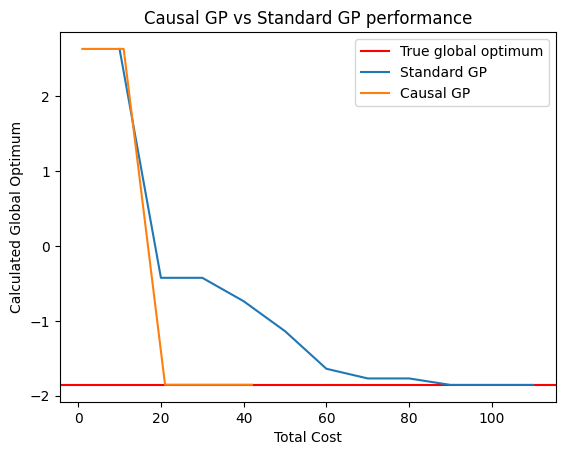

In [15]:
from causalbo.do_calculus import E_output_given_do, SCM
from causalbo.causal_helper_funcs import calculate_epsilon, subdict_with_keys, df_to_tensor
import numpy as np
import torch
from matplotlib import pyplot as plt
from causalbo.sample_data.toy_graph import ToyGraph
from causalbo.cbo_loop import CBOLoop

from causalbo.modules import CausalMean, CausalRBF
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

NUM_INITIAL_OBSERVATIONS = 30 
INTERVENTION_COST = 10
OBSERVATION_COST = 1

toy_graph = ToyGraph()

num_iterations = 20

train_x_standard = df_to_tensor(toy_graph.observational_samples.loc[:NUM_INITIAL_OBSERVATIONS,toy_graph.observational_samples.columns != toy_graph.graph.output_node])
train_y_standard = df_to_tensor(toy_graph.observational_samples.loc[:NUM_INITIAL_OBSERVATIONS,toy_graph.observational_samples.columns == toy_graph.graph.output_node])

# Store total cost
total_cost_standard = NUM_INITIAL_OBSERVATIONS
# Store optimal value
global_optimum_standard = max(toy_graph.observational_samples[toy_graph.graph.output_node])
# Store changes in cost over time
cost_over_time_standard = []
# Store optimum over time
global_optimum_over_time_standard = []
# Standard intervention set is all non-output nodes
intervention_set_standard = toy_graph.observational_samples.loc[:,toy_graph.observational_samples.columns != toy_graph.graph.output_node].columns.tolist()


# Initialize Standard GP

gp_standard = SingleTaskGP(train_X=train_x_standard, train_Y=train_y_standard)
mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)
fit_gpytorch_model(mll)

# global_optimum_over_time_standard.append(global_optimum_standard)
# cost_over_time_standard.append(total_cost_standard)

true_ys = torch.tensor([[global_optimum_standard]])

# Optimization loop
for i in range(num_iterations):
    cost_over_time_standard.append(total_cost_standard)
    global_optimum_over_time_standard.append(global_optimum_standard)
    print(f'Standard GP, iteration {i}')
    candidate, _ = optimize_acqf(
        acq_function=acqf,
        bounds=torch.tensor(list(subdict_with_keys(toy_graph.interventional_domain, intervention_set_standard).values()), dtype=torch.float64).t(),
        q=1,
        num_restarts=5,
        raw_samples=20,
    )   

    # Evaluate the objective function at the new candidate point
    new_x = candidate.detach()
    new_y = torch.tensor([[E_output_given_do(interventional_variable=intervention_set_standard, interventional_value=np.array(torch.flatten(new_x)), causal_model=toy_graph.true_graph)]])
    
    # Update the training data
    train_x_standard = torch.cat([train_x_standard, new_x])
    train_y_standard = torch.cat([train_y_standard, new_y])

    true_ys = torch.cat([true_ys, new_y], dim=1)

    # Update the GP model and fit the hyperparameters
    gp_standard = SingleTaskGP(train_x_standard, train_y_standard)
    mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
    fit_gpytorch_model(mll)

    # Update the acquisition function with new observations
    global_optimum_standard = torch.min(true_ys)
    acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)

    # Update cost and optimum
    total_cost_standard += INTERVENTION_COST * len(intervention_set_standard)
    
cost_over_time_standard.append(total_cost_standard)
global_optimum_over_time_standard.append(global_optimum_standard)
# Output standard GP results
print(global_optimum_over_time_standard)


# Initialize and run Causal GP using the CBO algorithm from Aglietti et. al.
(global_optimum, global_optimal_set, gp, D_i, D_o, cost_over_time_causal, global_optimum_over_time_causal) = CBOLoop(
        observational_samples=toy_graph.observational_samples,
        graph=toy_graph.graph,
        exploration_set=[['Z']], # We are allowed to examine fewer variables here since we know the POMIS is ['Z'] and the causal GP can take advantage of this, while the standard cannot
        num_steps=num_iterations,
        num_initial_obs=NUM_INITIAL_OBSERVATIONS,
        num_obs_per_step=20,
        num_max_allowed_obs=1000,
        interventional_domain=toy_graph.interventional_domain,
        type_trial='min',
        objective_function=toy_graph.true_graph,
        early_stopping_iters=10, verbose=True)

idx = global_optimum_over_time_causal.index(global_optimum) + 1
global_optimum_over_time_causal = [global_optimum_over_time_causal[0]] + global_optimum_over_time_causal[:idx]
cost_over_time_causal = [0] + cost_over_time_causal[:idx]

plt.plot([0] + cost_over_time_standard, [global_optimum_over_time_standard[0]] + global_optimum_over_time_standard, "-o")
plt.plot(cost_over_time_causal, global_optimum_over_time_causal, "-o")
plt.plot()
plt.legend(['Standard GP', 'Causal GP'])
plt.xlabel("Total Cost\nObservation costs 1 unit per point, intervention costs 10 units per variable")
plt.ylabel("Global Optimum")
plt.title("Standard GP vs Causal GP: Toy Graph, 20 iterations")
plt.show()

### Medical Graph

Fitting causal mechanism of node STATIN: 100%|██████████| 6/6 [00:00<00:00, 29.72it/s] 


Standard GP, iteration 0
Standard GP, iteration 1
Standard GP, iteration 2
Standard GP, iteration 3
Standard GP, iteration 4
Standard GP, iteration 5
Standard GP, iteration 6
Standard GP, iteration 7
Standard GP, iteration 8
Standard GP, iteration 9
[7.592174530029297, tensor(4.9424, dtype=torch.float64), tensor(3.6101, dtype=torch.float64), tensor(3.2376, dtype=torch.float64), tensor(3.2376, dtype=torch.float64), tensor(3.0209, dtype=torch.float64), tensor(3.0209, dtype=torch.float64), tensor(3.0209, dtype=torch.float64), tensor(3.0004, dtype=torch.float64), tensor(3.0004, dtype=torch.float64), tensor(3.0004, dtype=torch.float64)]
Iteration 0
Current global optimal set-value-result = ['None']: None -> 6.538609981536865
Epsilon: 1 - Uniform: 0.1330905082036995
Observing 20 new data points.


Fitting causal mechanism of node STATIN: 100%|██████████| 6/6 [00:00<00:00, 864.06it/s]


Iteration 1
Current global optimal set-value-result = ['None']: None -> 6.538609981536865
Epsilon: 0 - Uniform: 0.5155447849254226
Intervening...
Optimal set-value pair: ASPIRINSTATIN - [0.07128455210477114, 0.9413150539621711]
Updating D_i for ASPIRINSTATIN...
Updating GP posterior for ASPIRINSTATIN...
Updating global optimum...
Iteration 2
Current global optimal set-value-result = ['ASPIRIN', 'STATIN']: [0.07128455210477114, 0.9413150539621711] -> 3.3952145352236305
Epsilon: 0.021621978160402837 - Uniform: 0.6730263381719446
Intervening...
Optimal set-value pair: ASPIRINSTATIN - [0.021113718090202765, 0.27839455534797686]
Updating D_i for ASPIRINSTATIN...
Updating GP posterior for ASPIRINSTATIN...
Updating global optimum...
Iteration 3
Current global optimal set-value-result = ['ASPIRIN', 'STATIN']: [0.07128455210477114, 0.9413150539621711] -> 3.3952145352236305
Epsilon: 0.021621978160402837 - Uniform: 0.7491831717719277
Intervening...
Optimal set-value pair: ASPIRINSTATIN - [2.67604

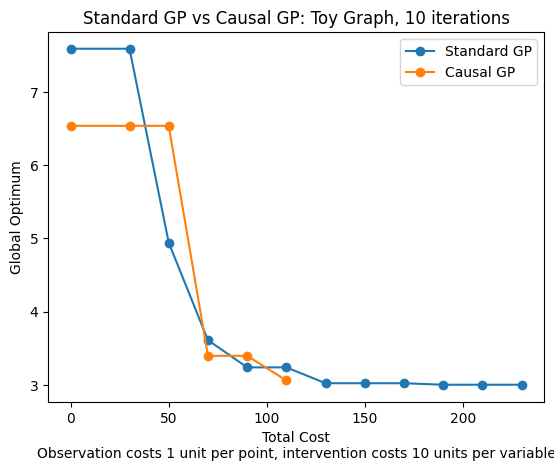

In [27]:
from causalbo.do_calculus import E_output_given_do
from causalbo.causal_helper_funcs import subdict_with_keys, df_to_tensor
import numpy as np
import torch
from matplotlib import pyplot as plt
from causalbo.sample_data.psa_graph import PSAGraph
from causalbo.cbo_loop import CBOLoop

from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

NUM_INITIAL_OBSERVATIONS = 30 
INTERVENTION_COST = 10
OBSERVATION_COST = 1

# PSAGraph object is a prebuilt class containing the medical dataset.
toy_graph = PSAGraph()

num_iterations = 10

train_x_standard = df_to_tensor(toy_graph.observational_samples.loc[:1][['ASPIRIN', 'STATIN']])
train_y_standard = df_to_tensor(toy_graph.observational_samples.loc[:1,toy_graph.observational_samples.columns == toy_graph.graph.output_node])

# Store total cost
total_cost_standard = NUM_INITIAL_OBSERVATIONS
# Store optimal value
global_optimum_standard = max(toy_graph.observational_samples[toy_graph.graph.output_node])
# Store changes in cost over time
cost_over_time_standard = []
# Store optimum over time
global_optimum_over_time_standard = []
# Standard intervention set is all non-output nodes
intervention_set_standard = ['ASPIRIN', 'STATIN']

# Initialize Standard GP
gp_standard = SingleTaskGP(train_X=train_x_standard, train_Y=train_y_standard)
mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)
fit_gpytorch_model(mll)

true_ys = torch.tensor([[global_optimum_standard]])

# Optimization loop
for i in range(num_iterations):
    cost_over_time_standard.append(total_cost_standard)
    global_optimum_over_time_standard.append(global_optimum_standard)
    print(f'Standard GP, iteration {i}')
    candidate, _ = optimize_acqf(
        acq_function=acqf,
        bounds=torch.tensor(list(subdict_with_keys(toy_graph.interventional_domain, intervention_set_standard).values()), dtype=torch.float64).t(),
        q=1,
        num_restarts=5,
        raw_samples=20,
    )   

    # Evaluate the objective function at the new candidate point
    new_x = candidate.detach()
    new_y = torch.tensor([[E_output_given_do(interventional_variable=intervention_set_standard, interventional_value=np.array(torch.flatten(new_x)), causal_model=toy_graph.true_graph)]])
    
    # Update the training data
    train_x_standard = torch.cat([train_x_standard, new_x])
    train_y_standard = torch.cat([train_y_standard, new_y])

    true_ys = torch.cat([true_ys, new_y], dim=1)

    # Update the GP model and fit the hyperparameters
    gp_standard = SingleTaskGP(train_x_standard, train_y_standard)
    mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
    fit_gpytorch_model(mll)

    # Update the acquisition function with new observations
    global_optimum_standard = torch.min(true_ys)
    acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)

    # Update cost and optimum
    total_cost_standard += INTERVENTION_COST * len(intervention_set_standard)
    
cost_over_time_standard.append(total_cost_standard)
global_optimum_over_time_standard.append(global_optimum_standard)
# Output standard GP results
print(global_optimum_over_time_standard)


# Initialize and run Causal GP using the CBO algorithm from Aglietti et. al.
(global_optimum, global_optimal_set, gp, D_i, D_o, cost_over_time_causal, global_optimum_over_time_causal) = CBOLoop(
        observational_samples=toy_graph.observational_samples,
        graph=toy_graph.graph,
        exploration_set=[['ASPIRIN', 'STATIN']],
        num_steps=num_iterations,
        num_initial_obs=NUM_INITIAL_OBSERVATIONS,
        num_obs_per_step=20,
        num_max_allowed_obs=1000,
        interventional_domain=toy_graph.interventional_domain,
        type_trial='min',
        objective_function=toy_graph.true_graph,
        early_stopping_iters=10, verbose=True)

idx = global_optimum_over_time_causal.index(global_optimum) + 1
global_optimum_over_time_causal = [global_optimum_over_time_causal[0]] + global_optimum_over_time_causal[:idx]
cost_over_time_causal = [0] + cost_over_time_causal[:idx]

plt.plot([0] + cost_over_time_standard, [global_optimum_over_time_standard[0]] + global_optimum_over_time_standard, "-o")
plt.plot(cost_over_time_causal, global_optimum_over_time_causal, "-o")
plt.plot()
plt.legend(['Standard GP', 'Causal GP'])
plt.xlabel("Total Cost\nObservation costs 1 unit per point, intervention costs 10 units per variable")
plt.ylabel("Global Optimum")
plt.title("Standard GP vs Causal GP: Toy Graph, 10 iterations")
plt.show()